[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Denis-R-V/TSR/blob/main/3.sign_detector.ipynb)

# Система распознавания дорожных знаков на датасете RTSD

In [1]:
colab = False

if colab == True:
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install kaggle
    !mkdir ~/.kaggle
    !cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
    !kaggle datasets download watchman/rtsd-dataset
    !unzip rtsd-dataset.zip -d ./data/RTSD
    !rm rtsd-dataset.zip
    !cp -r data/RTSD/rtsd-frames/rtsd-frames/ data/RTSD/
    !rm -r data/RTSD/rtsd-frames/rtsd-frames/
    !pip install fiftyone

In [181]:
import os
#import json
import numpy as np 
#import pandas as pd 

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

from pycocotools.coco import COCO
#import fiftyone as fo
#import time
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
#import torchvision.transforms as transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
#from torchvision.models.detection import FasterRCNN
#import cv2

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

## Обучение модели

### Пути и параметры

In [3]:
dataset_path = 'data/RTSD'
checkpoints_path = 'checkpoints' if colab == False else '../content/drive/MyDrive/TSR/checkpoints'

batch_size = 8
num_classes = 2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.get_device_name(0) if device.type == 'cuda' else device.type)

NVIDIA GeForce RTX 3090


### Загрузчик данных

In [5]:
class RTSD_dataset_one_class(Dataset):
    '''
    Faster R-CNN при обучении ожидает на вход:
    - список тензоров размерностью [C, H, W] для каждого изображения со значениями в диапазоне 0-1
    - таргет: список словарей с ключами:
                - boxes (FloatTensor[N, 4]): ограничивающие рамки ground-truth в формате [x1, y1, x2, y2], с 0 <= x1 < x2 <= W и 0 <= y1 < y2 <= H.
                - labels (Int64Tensor[N]): метки классов для каждой ограничивающей рамки ground-truth (включая background)
    '''
    
    
    def __init__(self, root, annotation, transforms=None):
        super().__init__()
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        # Файл coco
        coco = self.coco
        # Image ID
        img_id = self.ids[index]
        # List: получение ID аннотаций из coco
        ann_ids = coco.getAnnIds(imgIds=img_id)
        # Dictionary: загрузка аннатаций для изображения
        coco_annotation = coco.loadAnns(ann_ids)
        # Путь к изображению
        path = coco.loadImgs(img_id)[0]['file_name']
        
        # Загрузка изображения
        #img = cv2.imread(os.path.join(self.root, path))
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # загрузка с помощью PIL оказалась быстрее, чем с помощью OpenCV
        img = Image.open(os.path.join(self.root, path))
        img = np.array(img)

        # Количество объектов на изображении
        num_objs = len(coco_annotation)
        
        # Bounding boxes для объектов
        # В coco формате bbox = [xmin, ymin, width, height]
        # Для pytorch bbox должны быть в формате [xmin, ymin, xmax, ymax]
        boxes = []
        #labels = []
        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
            #labels.append(coco_annotation[i]['category_id'])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # Метки классов
        #labels = torch.as_tensor(labels, dtype=torch.int64)
        # Используется только 1 класс - знак
        labels = torch.ones((num_objs,), dtype=torch.int64)  
   
        if self.transforms is not None:
            transformed = self.transforms(image=img, bboxes=boxes, labels=labels)
            img = transformed['image']
            boxes = transformed['bboxes']

        img = img/255   

        # Аннотация в формате словаря
        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels

        return img, my_annotation

    def __len__(self):
        return len(self.ids)

In [6]:
# При параметре train=True выполняется аугментация и преобразование в тензор
# При параметре train=Афдыу выполняется только преобразование в тензор
def get_transform(train=False):
    if train==True:
        return A.Compose([A.HorizontalFlip(p=0.5),
                          A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.8),
                          A.RandomFog(fog_coef_lower=0.2, fog_coef_upper=0.3, alpha_coef=0.1, p=0.05), #Туман
                          A.RandomRain(brightness_coefficient=0.9, drop_width=1, blur_value=5, p=0.05),
                          A.Rotate(limit=10, p=0.5),
                          #A.RandomShadow(num_shadows_lower=1, num_shadows_upper=1, shadow_dimension=5, shadow_roi=(0, 0.5, 1, 1), p=1),
                          #A.RandomSnow(brightness_coeff=1.5, snow_point_lower=0.3, snow_point_upper=0.5, p=1),
                          #A.RandomSunFlare(flare_roi=(0, 0, 1, 0.5), angle_lower=0.5, p=1),
                          # ToTensorV2 конвертирует изображение в pytorch тензор без деления на 255
                          ToTensorV2(p=1.0)
                          ],
                          bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))
        
    else:
        return A.Compose([ToTensorV2(p=1.0)],
                         bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

In [190]:
train_dataset = RTSD_dataset_one_class(dataset_path,
                                       os.path.join(dataset_path, 'train_anno.json'),
                                       transforms = get_transform(train=True)
                                       )

loading annotations into memory...
Done (t=0.26s)
creating index...
index created!


In [178]:
def plot_img_bbox(img, target):
    # функция отрисовки изображения и ограничивающих рамок (x-min y-min width height)
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(10,10)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 1,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # отрисовка ограничивающих рамок на изображении
        a.add_patch(rect)
    plt.show()

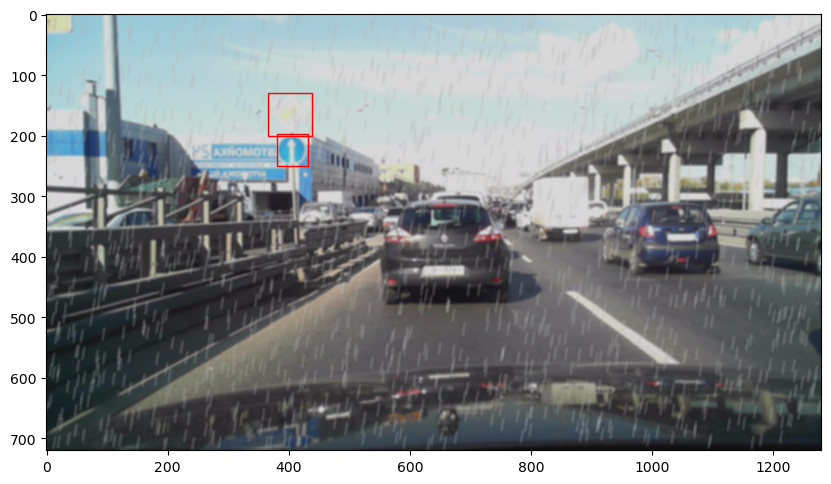

In [233]:
%matplotlib inline
img, target = train_dataset.__getitem__(4000)
img = (img.permute(1, 2, 0).detach().numpy()*255).astype(np.uint8)
plot_img_bbox(img, target)

### Формирование батча

In [179]:
def collate_fn(batch):
    return tuple(zip(*batch))

### Параметры модели и обучения

In [180]:
#model_name = 'resnet50_augmented'
model_name = 'resnet50_v2_augmented'

# эпоха для загрузки параметров, обучение начинается со следующей
last_epoch = None
n_epochs = 10       # полное количество эпох для обучения

### Инициализация модели, задание оптимизатора и функции потерь

In [234]:
def create_model(model_name, num_classes):
    # load model pre-trained on COCO
    if 'resnet50_v2' in model_name:
        model =torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights='FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT')
        print("Загружена модель resnet50_v2")
    elif 'resnet50' in model_name:
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='FasterRCNN_ResNet50_FPN_Weights.COCO_V1')
        print("Загружена модель resnet50")
    else:
        print("Проверить название модели")
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [236]:
model = create_model(model_name=model_name, num_classes=2).to(device)

# parameters
params = [p for p in model.parameters() if p.requires_grad]

# optimizer
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0005)
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0005)

# learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

# Загрузка весов модели, состояния оптимизатора и шедулера
if last_epoch is not None:
    checkpoint = torch.load(os.path.join(checkpoints_path, f'chkpt_detector_{model_name}_b{batch_size}_{last_epoch}.pth'), map_location=device)
    print(f'Для модели {model_name} с размером батча {batch_size} загружены веса {last_epoch} эпохи')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    lr_scheduler.load_state_dict(checkpoint['lr_scheduler_state_dict'])

train_dataset = RTSD_dataset_one_class(dataset_path,
                                       os.path.join(dataset_path, 'train_anno.json'),
                                       transforms = get_transform(train=True)
                                       )

val_dataset = RTSD_dataset_one_class(dataset_path,
                                     os.path.join(dataset_path, 'val_anno.json'),
                                     transforms = get_transform(train=False)
                                     )

train_data_loader = DataLoader(train_dataset,
                               batch_size=batch_size,
                               shuffle=True,
                               collate_fn=collate_fn
                               )

val_data_loader = DataLoader(val_dataset,
                             batch_size=batch_size,
                             shuffle=False,
                             collate_fn=collate_fn
                             )

Загружена модель resnet50_v2
loading annotations into memory...
Done (t=0.27s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


### Трейн луп

In [8]:
def train(train_dataloader, epoch): 
    len_dataloader = len(train_dataloader)
    model.train()
    running_loss = 0
    for i, data in enumerate(train_dataloader):
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        if i % 50 == 0:
            print(f"\tЭпоха {epoch}. Итерация {i}/{len_dataloader}. Loss: {loss}")
    train_loss = running_loss/len(train_dataloader.dataset)
    return train_loss

def val(val_dataloader, epoch):
    running_loss = 0
    for data in val_dataloader:
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.no_grad():
            loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        running_loss += loss.item()
    val_loss = running_loss/len(val_dataloader.dataset)
    return val_loss 

In [9]:
# Загрузка словарей с лоссами
if last_epoch is not None:
    start_epoch = last_epoch +1
    train_losses = checkpoint['losses_train']
    val_losses = checkpoint['losses_val']
    
else:
    start_epoch = 0
    train_losses = []
    val_losses = []

try:
    for epoch in range(start_epoch, n_epochs):
        start = time.time()
        train_loss = train(train_data_loader, epoch)
        val_loss = val(val_data_loader, epoch)
        lr_scheduler.step()
        print(f"Эпоха #{epoch} train_loss: {train_loss}, val_loss: {val_loss}")  
        end = time.time()
        print(f"Потрачено {round((end - start) / 60, 1)} минут на {epoch} эпоху")
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler_state_dict': lr_scheduler.state_dict(),
            'losses_train': train_losses,
            'losses_val': val_losses
            }, os.path.join(checkpoints_path, f'chkpt_detector_{model_name}_b{batch_size}_{epoch}.pth'))
    
        torch.save(model, os.path.join(checkpoints_path, f'model_detector_{model_name}_b{batch_size}_{epoch}.pth'))
    
except KeyboardInterrupt:
    print('Прервано пользователем') 

	Эпоха 0. Итерация 0/6774. Loss: 0.9390807151794434
	Эпоха 0. Итерация 50/6774. Loss: 0.11734501272439957
	Эпоха 0. Итерация 100/6774. Loss: 0.11606228351593018
	Эпоха 0. Итерация 150/6774. Loss: 0.07117254287004471
	Эпоха 0. Итерация 200/6774. Loss: 0.05536134913563728
	Эпоха 0. Итерация 250/6774. Loss: 0.051997117698192596
	Эпоха 0. Итерация 300/6774. Loss: 0.07136837393045425
	Эпоха 0. Итерация 350/6774. Loss: 0.04733286052942276
	Эпоха 0. Итерация 400/6774. Loss: 0.11375754326581955
	Эпоха 0. Итерация 450/6774. Loss: 0.09509801119565964
	Эпоха 0. Итерация 500/6774. Loss: 0.09815475344657898
	Эпоха 0. Итерация 550/6774. Loss: 0.2578848600387573
	Эпоха 0. Итерация 600/6774. Loss: 0.0717872828245163
	Эпоха 0. Итерация 650/6774. Loss: 0.1082683578133583
	Эпоха 0. Итерация 700/6774. Loss: 0.09348393976688385
	Эпоха 0. Итерация 750/6774. Loss: 0.0707588717341423
	Эпоха 0. Итерация 800/6774. Loss: 0.06131155416369438
	Эпоха 0. Итерация 850/6774. Loss: 0.09362815320491791
	Эпоха 0. Итераци

In [ ]:
def create_model(num_classes, pretrained=True):
    model =torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(weights='FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT')
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [ ]:
model = create_model(num_classes=2, pretrained=True).to(device)




# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

#params = [p for p in model.parameters() if p.requires_grad]

#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0005)
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0005)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)



#optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
train_dataset = RTSD_dataset(os.path.join(dataset_path, 'train_anno_bin_class.json'),
                                          dataset_path)
val_dataset = RTSD_dataset(os.path.join(dataset_path, 'val_anno_bin_class.json'), dataset_path)

train_data_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    #num_workers=4,
    collate_fn=collate_fn
)

val_data_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    #num_workers=4,
    collate_fn=collate_fn
)

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to C:\Users\User/.cache\torch\hub\checkpoints\fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth


  0%|          | 0.00/74.2M [00:00<?, ?B/s]

In [ ]:
def train(train_dataloader, epoch): 
    len_dataloader = len(train_dataloader)
    model.train()
    running_loss = 0
    for i, data in enumerate(train_dataloader):
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        if i % 50 == 0:
            print(f"\tЭпоха {epoch}. Итерация {i}/{len_dataloader}. Loss: {loss}")
    train_loss = running_loss/len(train_dataloader.dataset)
    return train_loss

def val(val_dataloader, epoch):
    running_loss = 0
    for data in val_dataloader:
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.no_grad():
            loss_dict = model(images, targets)
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        running_loss += loss.item()
    val_loss = running_loss/len(val_dataloader.dataset)
    return val_loss 

In [ ]:
train_losses = []
val_losses = []
try:
    for epoch in range(n_epochs):
        start = time.time()
        train_loss = train(train_data_loader, epoch)
        val_loss = val(val_data_loader, epoch)
        #lr_scheduler.step()
        print(f"Эпоха #{epoch} train_loss: {train_loss}, val_loss: {val_loss}")  
        end = time.time()
        print(f"Потрачено {round((end - start) / 60, 1)} минут на {epoch} эпоху")
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler_state_dict': lr_scheduler.state_dict(),
            'losses_train': train_losses,
            'losses_val': val_losses
            }, os.path.join(dataset_path, f'../checkpoints/model_detector_resnet50_augmented_{epoch}.pth'))
    torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'lr_scheduler_state_dict': lr_scheduler.state_dict(),
    'losses_train': train_losses,
    'losses_val': val_losses
    }, os.path.join(dataset_path, f'../checkpoints/model_detector_resnet50_augmented_full.pth'))
except KeyboardInterrupt:
    print('Прервано пользователем')

	Эпоха 0. Итерация 0/6774. Loss: 0.8358988165855408
	Эпоха 0. Итерация 50/6774. Loss: 0.09858530014753342
	Эпоха 0. Итерация 100/6774. Loss: 0.2172754555940628
	Эпоха 0. Итерация 150/6774. Loss: 0.40015822649002075
	Эпоха 0. Итерация 200/6774. Loss: 0.13395972549915314
	Эпоха 0. Итерация 250/6774. Loss: 0.28839361667633057
	Эпоха 0. Итерация 300/6774. Loss: 0.2116183489561081
	Эпоха 0. Итерация 350/6774. Loss: 0.2833598256111145
	Эпоха 0. Итерация 400/6774. Loss: 0.2793215811252594
	Эпоха 0. Итерация 450/6774. Loss: 0.309714674949646
	Эпоха 0. Итерация 500/6774. Loss: 0.20718857645988464
	Эпоха 0. Итерация 550/6774. Loss: 0.26163995265960693
	Эпоха 0. Итерация 600/6774. Loss: 0.35022008419036865
	Эпоха 0. Итерация 650/6774. Loss: 0.25102320313453674
	Эпоха 0. Итерация 700/6774. Loss: 0.36677470803260803
	Эпоха 0. Итерация 750/6774. Loss: 0.34893864393234253
	Эпоха 0. Итерация 800/6774. Loss: 0.32514622807502747
	Эпоха 0. Итерация 850/6774. Loss: 0.2878253161907196
	Эпоха 0. Итерация 90

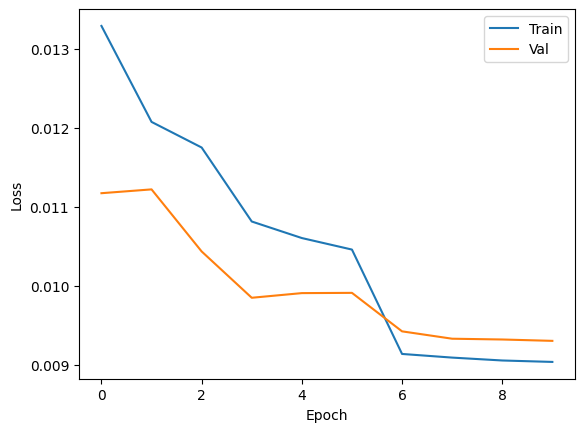

In [18]:
%matplotlib inline
fig, ax = plt.subplots()
ax.plot(train_losses, label='Train')
ax.plot(val_losses, label='Val')
#ax.plot(val_losses, label='Val')
ax.set(xlabel='Epoch', ylabel='Loss')
ax.legend()
plt.show()

In [ ]:
привет, Денис

In [ ]:
%matplotlib inline
fig, ax = plt.subplots()
ax.plot(train_losses, label='Train')
ax.plot(val_losses, label='Val')
#ax.plot(val_losses, label='Val')
ax.set(xlabel='Epoch', ylabel='Loss')
ax.legend()
plt.show()